### Basic Imports

In [2]:
import os
os.getcwd()

'/Users/chris/Desktop/pymc3-newbackends/pymc3/examples_tf'

In [3]:
import sys
sys.path.append('/Users/chris/Desktop/pymc3-newbackends/')

In [4]:
import pymc3 as pm
pm.__file__

/Users/chris/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'/Users/chris/Desktop/pymc3-newbackends/pymc3/__init__.py'

In [5]:
import theano as T
T.__file__

'/Users/chris/anaconda/lib/python3.6/site-packages/theano/__init__.py'

In [6]:
import tensorflow as tf
tf.__file__

'/Users/chris/anaconda/lib/python3.6/site-packages/tensorflow/__init__.py'

## A motivating example: Linear Regression

### Generate Data:  A motivating example: Linear Regression

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

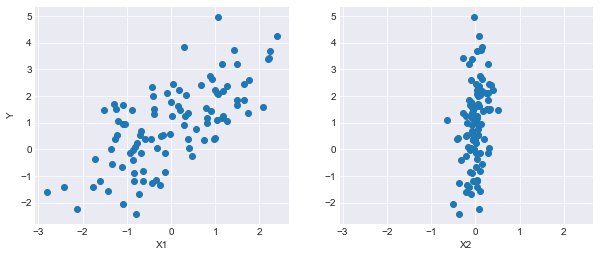

In [8]:
%matplotlib inline 

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

### Theano

In [12]:
basic_model = pm.Model()

with basic_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [16]:
map_estimate = pm.find_MAP(model=basic_model)
    
map_estimate

logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 111.06it/s] 


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma': array(0.96298858),
 'sigma_log__': array(-0.03771373)}

In [17]:
from scipy import optimize

map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)
    
map_estimate

/Users/chris/Desktop/pymc3-newbackends/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -149.47:   4%|▎         | 176/5000 [00:00<00:01, 2661.39it/s]

Optimization terminated successfully.
         Current function value: 148.984564
         Iterations: 4
         Function evaluations: 176


{'alpha': array(0.90907964),
 'beta': array([0.9514399 , 2.61452795]),
 'sigma': array(0.96568062),
 'sigma_log__': array(-0.03492212)}

In [18]:
from scipy import optimize

with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, beta, alpha]
100%|██████████| 1000/1000 [00:01<00:00, 704.06it/s]


In [19]:
with basic_model:
    
    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    
    # instantiate sampler
    #step = pm.Slice() 
    step = pm.Metropolis()
    
    # draw 5000 posterior samples
    trace_met = pm.sample(5000, step=step, start=start) 

/Users/chris/Desktop/pymc3-newbackends/pymc3/tuning/starting.py:92: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -149.47:   4%|▎         | 176/5000 [00:00<00:01, 2509.44it/s]


Optimization terminated successfully.
         Current function value: 148.984564
         Iterations: 4
         Function evaluations: 176


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma_log__]
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 5500/5500 [00:02<00:00, 2044.25it/s]
The number of effective samples is smaller than 10% for some parameters.


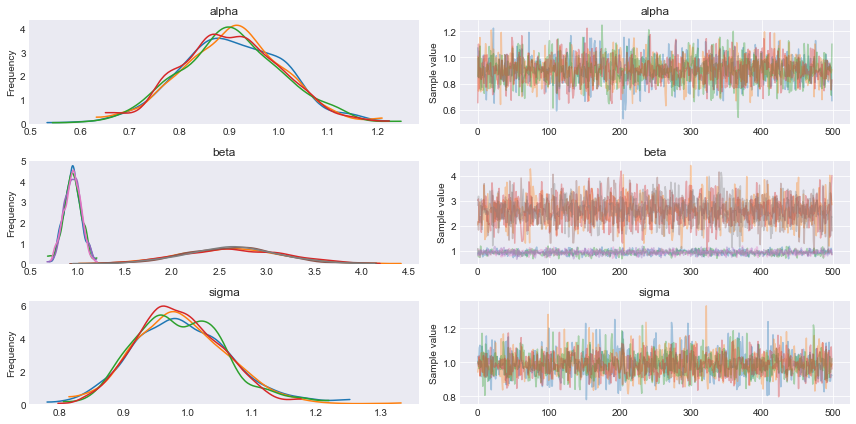

In [20]:
_ = pm.traceplot(trace)

In [21]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.904624,0.103645,0.001972,0.700515,1.109831,3025.376493,0.999111
beta__0,0.948232,0.090020,0.001702,0.769946,1.120354,2905.560555,0.999297
beta__1,2.620486,0.522051,0.011045,1.617584,3.673238,2325.086740,0.999435
sigma,0.988719,0.071651,0.001306,0.849799,1.125958,2915.507578,1.000073


## Stepping Through and Identifying Theano (keep restarting from here)


In [1]:
import sys
sys.path.append('/Users/chris/Desktop/pymc3-newbackends/')
import pymc3 as pm

/Users/chris/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#import imp
#imp.reload(pymc3)
#from pymc3 import model
#from pymc3 import distributions
#imp.reload(model)
#imp.reload(distributions) # these fuck up the context on the stack hmm. 

In [3]:
# it uses 'Context'
# ... this uses __enter__ and __exit___ in lines 160 of model.py
# and also 'InitContextMeta'
# that's because Model class is a subclass of multiple things Model(six.with_metaclass(InitContextMeta, Context, Factor, WithMemoization))
#basic_model = model.Model()

In [4]:
# basic_model = pm.Model()
# with basic_model:
#     alpha = pm.Normal('alpha', mu=0, sd=10)
    

In [5]:
# basic_model2 = pm.Model()
# with basic_model2:
#     alpha = pm.Normal('alpha', mu=0, sd=10)
    

In [6]:
import numpy as np

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [10]:
#%load_ext line_profiler

In [14]:
#%lprun -f basic_model2 = pm.Model()

In [7]:
basic_model2 = pm.Model()
with basic_model2: 
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

In [9]:
with basic_model2:
    
    # instantiate sampler
    step = pm.Metropolis()
    
    # draw 5000 posterior samples
    trace_met = pm.sample(chains=2,samples=5000, step=step) 

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma_log__]
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 1000/1000 [00:00<00:00, 2233.74it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


## Theano original

In [1]:
import sys
sys.path.append('/Users/chris/anaconda/envs/env_pymc3/lib/python3.6/')
sys.path.append('/Users/chris/anaconda/envs/env_pymc3/lib/python3.6/site-packages/')
import pymc3 as pm

/Users/chris/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
basic_model2 = pm.Model()
with basic_model2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    

## Now commenting out Theano in model.py


In [1]:
import sys
sys.path.append('/Users/chris/Desktop/pymc3-newbackends/')
import pymc3 as pm

/Users/chris/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
basic_model2 = pm.Model()
with basic_model2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    

## Adding in more variables


In [5]:
import sys
sys.path.append('/Users/chris/Desktop/pymc3-newbackends/')
import pymc3 as pm

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [7]:
basic_model2 = pm.Model()
with basic_model2:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=1.0, observed=Y)

In [8]:
with basic_model2:
    step = pm.Metropolis()

In [12]:
with basic_model2:
    trace = pm.sample(500,step=step) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 1000/1000 [00:01<00:00, 911.33it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [14]:
trace['alpha']

array([0.84980184, 0.84980184, 0.84980184, ..., 0.96304864, 0.8950866 ,
       0.8950866 ], dtype=float32)

## Testing new Function class

In [1]:
import sys
sys.path.append('/Users/chris/Desktop/pymc3-newbackends/')
import pymc3 as pm

/Users/chris/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
basic_model2 = pm.Model()
with basic_model2:
    alpha = pm.Normal('alpha', mu=0, sd=10)

## Testing Draw Values

In [1]:
import sys
sys.path.append('/Users/chris/Desktop/pymc3-newbackends/')
import pymc3 as pm

/Users/chris/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
basic_model2 = pm.Model()
with basic_model2:
    alpha = pm.Normal('alpha', mu=0, sd=10)

In [3]:
from pymc3.distributions import draw_values

In [6]:
draw_values(alpha)

TypeError: TensorType does not support iteration. Maybe you are using builtin.sum instead of theano.tensor.sum? (Maybe .max?)

## Trying TensorFlow

- start with distribution and continuous first. 

In [4]:
import sys
sys.path.append('/Users/chris/Desktop/pymc3-newbackends/')
import tensorflow as tf

/Users/chris/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import theano.tensor as tt 

In [6]:
X = tt.TensorType(str('float32'), [True])
#print(X)

In [7]:
a = {}
a['test_value']=[]
#a.test_value


In [8]:
B = tf.Variable(10)
A = tf.Variable(10)
s = B+A
s

<tf.Tensor 'add:0' shape=() dtype=int32>

In [9]:
session = tf.Session()


In [10]:
session.run(tf.global_variables_initializer())

In [11]:
session.run(s,feed_dict={B:5,A:3})

8

In [18]:
A.name

'Variable_3:0'

In [65]:
# import numpy as np
# X = tt.TensorVariable(np.array([]),str('float32'))
# #type(X.tag)
# X.ndim

In [3]:

p = tf.placeholder(dtype='float64',shape=())
p

/Users/chris/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<tf.Tensor 'Placeholder:0' shape=() dtype=float64>

In [4]:
#session.run(tf.variables_initializer(uninitialized_vars),{'alpha:0':0.0})

In [16]:
A = tf.constant(value=10)
B = tf.Variable(10)
B

<tf.Variable 'Variable_2:0' shape=() dtype=int32_ref>

In [66]:
#tf.Tensor(name='test')
tf.Variable(initial_value=np.array([0.0,0.0]),name='test')

<tf.Variable 'test_1:0' shape=(2,) dtype=float64_ref>

In [34]:
#tf.Variable()
#type(tf.Variable())
print(tf.Variable)
print(tf.Variable)

<class 'tensorflow.python.ops.variables.Variable'>
<class 'tensorflow.python.ops.variables.Variable'>


In [8]:
variables = tf.global_variables()
variables

[<tf.Variable 'Variable:0' shape=() dtype=int32_ref>]

In [9]:
session.run(A)

10

In [12]:
session.run([B])

[10]

In [11]:
session.run([p],feed_dict={'Placeholder:0':0.0})

[array(0.)]

In [7]:
basic_model2 = pm.Model()

In [8]:
#basic_model2.

In [9]:
with basic_model2:
    alpha = pm.Normal('alpha', mu=0, sd=10)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder', defined at:
  File "/Users/chris/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/chris/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/chris/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/chris/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/chris/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/chris/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/chris/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/chris/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-86b2f0042124>", line 2, in <module>
    alpha = pm.Normal('alpha', mu=0, sd=10)
  File "/Users/chris/Desktop/pymc3-newbackends/pymc3/distributions/distribution.py", line 50, in __new__
    dist = cls.dist(*args, **kwargs)
  File "/Users/chris/Desktop/pymc3-newbackends/pymc3/distributions/distribution.py", line 61, in dist
    dist.__init__(*args, **kwargs)
  File "/Users/chris/Desktop/pymc3-newbackends/pymc3/distributions/continuous.py", line 314, in __init__
    super(Normal, self).__init__(**kwargs)
  File "/Users/chris/Desktop/pymc3-newbackends/pymc3/distributions/distribution.py", line 200, in __init__
    shape, dtype, defaults=defaults, *args, **kwargs)
  File "/Users/chris/Desktop/pymc3-newbackends/pymc3/distributions/distribution.py", line 72, in __init__
    self.type = placeholder(self.dtype,self.shape,broadcastable)
  File "/Users/chris/Desktop/pymc3-newbackends/pymc3/backends_symbolic/backends_tf.py", line 36, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1746, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3051, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/Users/chris/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder' with dtype float
	 [[Node: Placeholder = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [19]:
dir(alpha)
#'fastd2logp',
#'d2logp',
type(alpha)
id(alpha)
#globals()
alpha.d2logp
alpha.fastd2logp
alpha.logp.f